In [ ]:
%%capture
!pip install pybamm

In [ ]:
%%capture
!pip install import-ipynb

In [ ]:
import os
current_dir = os.getcwd()
new_dir = '/content/drive/MyDrive/Colab Notebooks/MeaTEC_Project'  # Replace with desired directory
os.chdir(new_dir)
print(f"Current working directory: {os.getcwd()}")
files_in_directory = os.listdir(current_dir) # List all files in the current directory

Current working directory: /content/drive/MyDrive/Colab Notebooks/MeaTEC_Project


In [ ]:
import pybamm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import import_ipynb
import DATA_Extraction_from_Liiondb
warnings.filterwarnings('ignore')

Prada2012
Prada2012
Srinivasan2004a
Ecker2015
Schmalstieg2018
Prada2012
Prada2012
Liebig2019
Birkl2015
Birkl2015
Birkl2015
Li2012
Hust2019
Dufour2018
Dufour2018
Kumaresan2008
Chaouachi2021


In [ ]:
Graphite_HOCVs_filtered,LFP_HOCVs,LFP_Paper_tags=DATA_Extraction_from_Liiondb.Graphite_HOCVs_filtered, DATA_Extraction_from_Liiondb.LFP_HOCVs,DATA_Extraction_from_Liiondb.LFP_Paper_tags

def half_cell_ocv_LFP_Kashkooli(x):
    U = 3.382 + 0.00470*x + 1.627*np.exp(-81.163*x**1.0138) + 7.6445E-8*np.exp(25.36*x**2.469) - 8.4410E-8*np.exp(25.262*x**2.478)
    return U

def halfcellocvThorat2011(x):
    U1 = 2.567462 + 57.69*(1-np.tanh(100*x + 2.9163927))
    U2 = 0.442953*np.arctan(-65.41928*x + 64.89741)
    U3 = 0.097237*np.arctan(-160.9058*x + 154.590)
    U = U1 + U2 + U3
    return U

Sel_Pos_OCV=[half_cell_ocv_LFP_Kashkooli,halfcellocvThorat2011]
Sel_Neg_OCV=Graphite_HOCVs_filtered[:-1] #[Ecker2015, Prada2012, Prada2015]

Final_Pos_OCV=Sel_Pos_OCV[1]

Final_Neg_OCV=Sel_Neg_OCV[2]
nocp_data=Final_Neg_OCV

In [ ]:
#import HOCVs_optimization_part2
#Final_Neg_OCV, Final_Pos_OCV=HOCVs_optimization_part2.Final_Neg_OCV,HOCVs_optimization_part2.Final_Pos_OCV

In [ ]:
df_dis_2=pd.read_csv('951_Cap_1Cb.csv')

In [ ]:
df_dis_2.drop(index=0, inplace=True)

In [ ]:
df_dis_2[['Voltage','Current']] = df_dis_2[['Voltage','Current']].astype(float)

In [ ]:
df_dis_2 = df_dis_2[df_dis_2['Current'] != 0]

In [ ]:
df_dis_2['Timeseries'] = np.arange(len(df_dis_2))*10
df_dis_2.head(3)

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt,Timeseries
8,10/16/2019 6:00:20 PM,39,DCH,58:42.6,00:10.0,0,0,A123_2p5Ah_ageing_90k_case,3.3665,-2.4998,23.7255,-0.0069,-0.0235,0,0
9,10/16/2019 6:00:30 PM,39,DCH,58:52.6,00:20.0,0,0,A123_2p5Ah_ageing_90k_case,3.3375,-2.4998,23.7255,-0.0139,-0.0468,0,10
10,10/16/2019 6:00:40 PM,39,DCH,59:02.6,00:30.0,0,0,A123_2p5Ah_ageing_90k_case,3.3198,-2.4998,23.7255,-0.0208,-0.0699,0,20


In [ ]:
df_dis_2['Current']=df_dis_2['Current']*-1

In [ ]:
drive1=df_dis_2[['Timeseries','Current']]

In [ ]:
drive1 = drive1.to_numpy()


In [ ]:
experiment = pybamm.Experiment([pybamm.step.current(drive1)])

In [ ]:
model = pybamm.lithium_ion.SPMe()

In [ ]:
params = pybamm.ParameterValues("Prada2013")

In [ ]:
params.update({"Electrode width [m]":0.0845,"Electrode height [m]":0.645,"Number of electrodes connected in parallel to make a cell":4})

In [ ]:
params.update({"Nominal cell capacity [A.h]":2.5,"Current function [A]":2.5})

In [ ]:
params.update({"Positive electrode OCP [V]":Final_Pos_OCV})

In [ ]:
nocp_data=Final_Neg_OCV
params.update({"Negative electrode OCP [V]":("half_cell_Negative",np.array(nocp_data))})

In [ ]:
simulation_diffusivity = [] # Store the simulation of positive particle diffusivity taken from liiondb.

In [ ]:
sim = pybamm.Simulation(model, parameter_values=params,experiment=experiment)
sol=sim.solve()
simulation_diffusivity.append(sim)

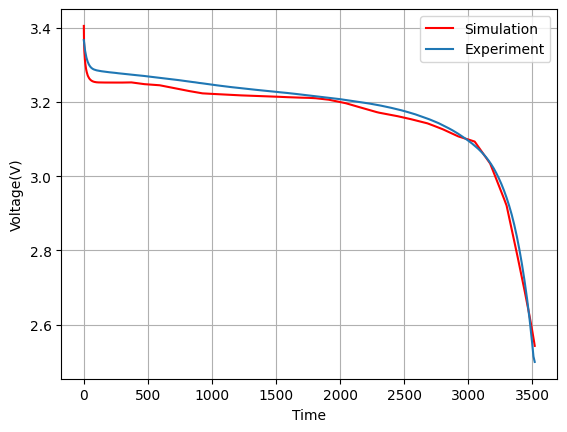

In [ ]:
plt.plot(sol["Time [s]"].data, sol["Terminal voltage [V]"].data,'red') # default pybamm Prada set positive partice diffusivity value
plt.plot(df_dis_2['Timeseries'], df_dis_2['Voltage']) # Experimental graph
plt.legend(['Simulation','Experiment'])
plt.xlabel('Time')
plt.ylabel('Voltage(V)')
plt.grid()

In [ ]:
def diffusion_coefficient_Kashkooli2016function(x,T):
    import numpy as np
    # FITTING:
    # Equations taken directly from paper table 3 and equation 12,13
    # Phase change model with thermodynamic factor for variable solid-state diffusivity in LFP

    import numpy as np

#     U = 3.382 + 0.00470*x + 1.627*np.exp(-81.163*x**1.0138) + 7.6445E-8*np.exp(25.36*x**2.469) - 8.4410E-8*np.exp(25.262*x**2.478)

    A1 = 1.627
    B1 = -81.163
    C1 = 1.0138
    A2 = 7.6445E-8
    B2 = 25.36
    C2 = 2.469
    A3 = -8.4410E-8
    B3 = 25.262
    C3 = 2.478

    U = 3.382 + 0.00470*x + A1*np.exp(B1*x**C1) + A2*np.exp(B2*x**C2) + A3*np.exp(B3*x**C3)
    dUdx = 0.00470 + A1*B1*C1*x**(C1-1)*np.exp(B1*x**C1) + A2*B2*C2*x**(C2-1)*np.exp(B2*x**C2) + A3*B3*C3*x**(C3-1)*np.exp(B3*x**C3)

    F = 96485.33212 #C/mol
    R = 8.31446261815324 #J/molK
    T = 298.15 #K
    gamma = -(F/(R*T))*x*(1-x)*dUdx

    D_LFP = 7E-16 #m2s18
    D = gamma*D_LFP

    return D


In [ ]:

def diffusion_coefficient_Farkhondeh2014function(x,T):
    import numpy as np
    # FITTING:
    # Equations taken directly from paper table 1
    import numpy as np

    A0 = 3.4510
    B0 = -8.8E-3
    A1 = 0.6678
    B1 = -81.002
    C1 = 1.1776
    A2 = 2.3738E-9
    B2 = 25.222
    C2 = 3.4801
    A3 = -2.6367E-9
    B3 = 25.12
    C3 = 3.4879

    U = A0 + B0*x + A1*np.exp(B1*x**C1) + A2*np.exp(B2*x**C2) + A3*np.exp(B3*x**C3)
    dUdx = B0 + A1*B1*C1*x**(C1-1)*np.exp(B1*x**C1) + A2*B2*C2*x**(C2-1)*np.exp(B2*x**C2) + A3*B3*C3*x**(C3-1)*np.exp(B3*x**C3)

    F = 96485.33212 #C/mol
    R = 8.31446261815324 #J/molK
    T = 298.15 #K
    alpha = -(F/(R*T))*x*(1-x)*dUdx

    D_LFP = 5E-17 #m2s19
    D = alpha*D_LFP

    return D


In [ ]:
d_coff=[diffusion_coefficient_Kashkooli2016function, diffusion_coefficient_Farkhondeh2014function,5.9e-10,5.9e-20,5.9e-16,5.9e-19] #Default Prada set positive particle diffusivity : 5.9e-18

In [ ]:
for i in d_coff:
  params.update({"Positive particle diffusivity [m2.s-1]":i})
  sim = pybamm.Simulation(model, parameter_values=params,experiment=experiment,solver=pybamm.IDAKLUSolver(rtol=0.0001, atol=1e-06, root_method='casadi', root_tol=1e-06, extrap_tol=None, output_variables=None, options=None))
  sol=sim.solve()
  simulation_diffusivity.append(sim)

2025-12-26 14:40:20.008 - [WARNING] callbacks.on_experiment_infeasible_event(254): 

	Experiment is infeasible: 'event: Minimum voltage [V]' was triggered during 'Step([[0.0000e+00 2.4998e+00]
 [1.0000e+01 2.4998e+00]
 [2.0000e+01 2.4998e+00]
 [3.0000e+01 2.4998e+00]
 [4.0000e+01 2.4998e+00]
 [5.0000e+01 2.4998e+00]
 [6.0000e+01 2.4998e+00]
 [7.0000e+01 2.4972e+00]
 [8.0000e+01 2.4998e+00]
 [9.0000e+01 2.4972e+00]
 [1.0000e+02 2.4998e+00]
 [1.1000e+02 2.4998e+00]
 [1.2000e+02 2.4998e+00]
 [1.3000e+02 2.4972e+00]
 [1.4000e+02 2.4998e+00]
 [1.5000e+02 2.4998e+00]
 [1.6000e+02 2.4998e+00]
 [1.7000e+02 2.4972e+00]
 [1.8000e+02 2.4998e+00]
 [1.9000e+02 2.4998e+00]
 [2.0000e+02 2.4998e+00]
 [2.1000e+02 2.4998e+00]
 [2.2000e+02 2.4972e+00]
 [2.3000e+02 2.4972e+00]
 [2.4000e+02 2.4998e+00]
 [2.5000e+02 2.4972e+00]
 [2.6000e+02 2.4998e+00]
 [2.7000e+02 2.4998e+00]
 [2.8000e+02 2.4998e+00]
 [2.9000e+02 2.4972e+00]
 [3.0000e+02 2.4998e+00]
 [3.1000e+02 2.4998e+00]
 [3.2000e+02 2.4998e+00]
 [3.300

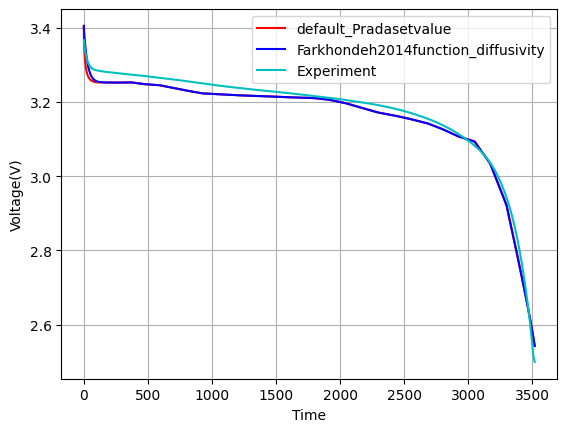

In [ ]:
plt.plot(simulation_diffusivity[0].solution["Time [s]"].data, simulation_diffusivity[0].solution["Terminal voltage [V]"].data,'r',label='default_Pradasetvalue')
#plt.plot(simulation_diffusivity[1].solution["Time [s]"].data, simulation_diffusivity[1].solution["Terminal voltage [V]"].data,'orange',label='Kashkooli2016function_diffusivity')
plt.plot(simulation_diffusivity[2].solution["Time [s]"].data, simulation_diffusivity[2].solution["Terminal voltage [V]"].data,'b',label='Farkhondeh2014function_diffusivity')
plt.plot(df_dis_2['Timeseries'],df_dis_2['Voltage'],color='c',label='Experiment')
plt.xlabel('Time')
plt.ylabel('Voltage(V)')
plt.legend()
plt.grid()


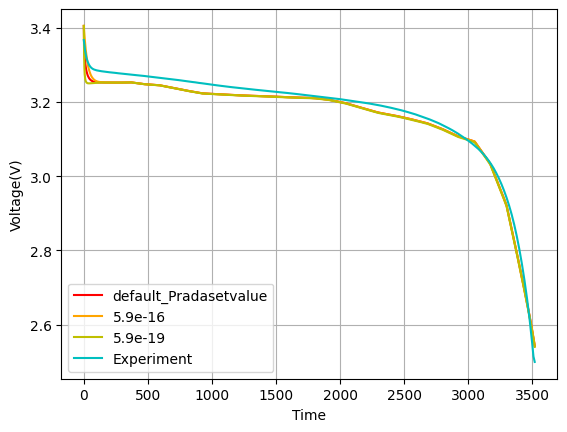

In [ ]:
plt.plot(simulation_diffusivity[0].solution["Time [s]"].data, simulation_diffusivity[0].solution["Terminal voltage [V]"].data,'r',label='default_Pradasetvalue')
#plt.plot(simulation_diffusivity[3].solution["Time [s]"].data, simulation_diffusivity[3].solution["Terminal voltage [V]"].data,'g',label='5.9e-10')
#plt.plot(simulation_diffusivity[4].solution["Time [s]"].data, simulation_diffusivity[4].solution["Terminal voltage [V]"].data,'blue',label='5.9e-20')
plt.plot(simulation_diffusivity[5].solution["Time [s]"].data, simulation_diffusivity[5].solution["Terminal voltage [V]"].data,'orange',label='5.9e-16')
plt.plot(simulation_diffusivity[6].solution["Time [s]"].data, simulation_diffusivity[6].solution["Terminal voltage [V]"].data,'y',label='5.9e-19')
plt.plot(df_dis_2['Timeseries'],df_dis_2['Voltage'],color='c',label='Experiment')
plt.xlabel('Time')
plt.ylabel('Voltage(V)')
plt.legend()
plt.grid()

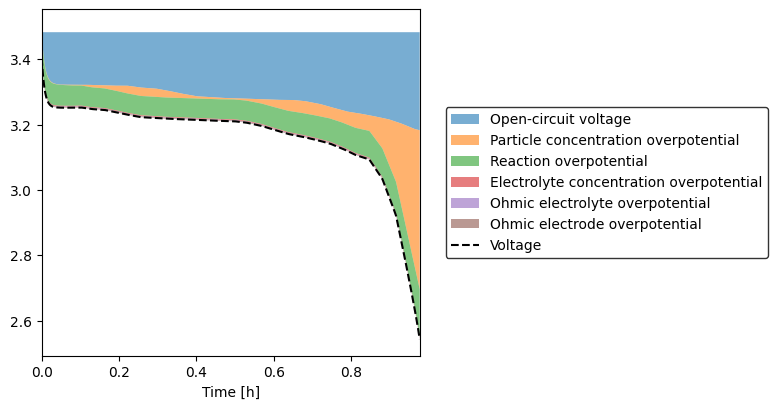

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [ ]:
simulation_diffusivity[5].plot_voltage_components()

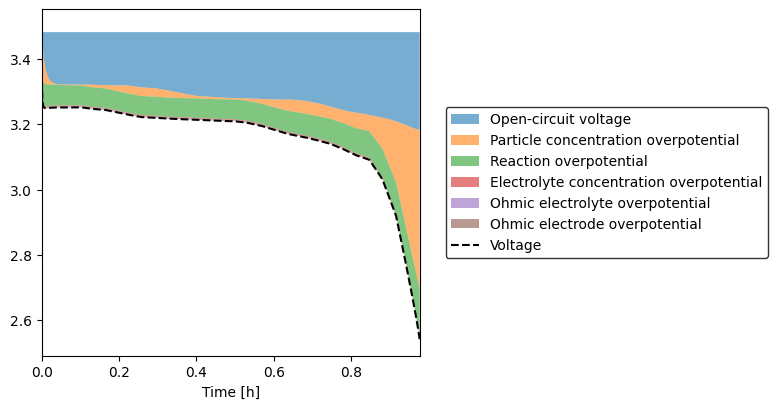

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [ ]:
simulation_diffusivity[6].plot_voltage_components()

In [ ]:
Final_pos_particle_diffusivity_bound=[5.9e-19,5.9e-16]